# 1.探索性数据分析

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sp
from scipy import stats
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split

import toad
from toad.plot import  bin_plot, badrate_plot 

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#pd.set_option('display.max_rows', None)
#显示所有行
#pd.set_option('display.max_columns', None)  
# 显示所有列

# 让notebook宽屏显示
from IPython.display import display, HTML
display(HTML('<style>.container{width:100% !important;}</style>'))

/Users/limeng/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# 读取数据
train = pd.read_csv('./data/train.csv')
target = pd.read_csv('./data/train_target.csv')
train.head()

,id,certId,loanProduct,gender,age,dist,edu,job,lmt,basicLevel,...,highestEdu,linkRela,setupHour,weekday,ncloseCreditCard,unpayIndvLoan,unpayOtherLoan,unpayNormalLoan,5yearBadloan,isNew
0,1,640582,1,2,27,640500,0,8,5.963,3,...,-999,0,9,6,1,0,1,0,0,1
1,2,621023,2,2,25,640600,0,3,6.467,3,...,99,11,6,5,1,0,1,0,0,1
2,3,641283,1,2,37,641200,70,5,0.596,1,...,70,0,1,6,0,0,0,0,0,1
3,4,340821,3,2,29,340821,0,4,6.300,3,...,-999,-999,13,6,1,0,1,0,0,1
4,5,732628,2,2,22,732628,0,2,6.700,2,...,99,11,8,3,1,0,1,0,0,1


In [3]:
train.shape

(132029, 104)

In [4]:
data_all = pd.merge(train, target)
data_all.head()
data_all.shape

(132029, 105)

### 数据预处理

#### 数据重复值与缺失值

In [5]:
# 含有缺失值的列
data_all.columns[data_all.isna().sum(axis=0) != 0]

# 将缺失值统一编码为-999，其余有bankcard的为0
data_all.bankCard.replace(-999, 1, inplace=True)
data_all.bankCard.fillna(1, inplace=True)
data_all.loc[data_all.bankCard > 1, 'bankCard'] = 0

#删掉无效特征
drop_col=['certId','dist','certValidBegin','certValidStop','residentAddr']
data_all.drop(columns=drop_col,inplace=True)

#异常值处理
data_all.drop(data_all.index[data_all.age > 100], inplace=True)

In [6]:
#查看重复值
data_all.duplicated().sum()

0

#### 查看标签分布

正负样本标签比为1: 136


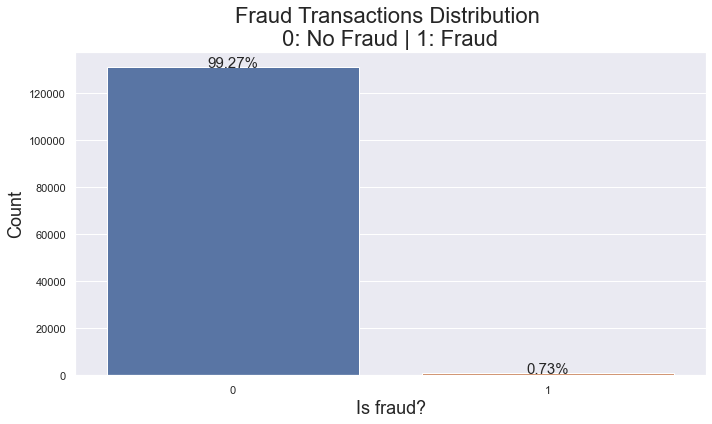

In [7]:
print('正负样本标签比为1:',int(sum(target.target == 0) / sum(target.target == 1)))

total = len(train)
plt.figure(figsize=(10,6), tight_layout=True)
g = sns.countplot(x='target', data=pd.concat([train, target.target], axis=1))
g.set_title("Fraud Transactions Distribution \n 0: No Fraud | 1: Fraud ", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15)
plt.show()

#### 划分训练集、测试集，初步观察数据

In [8]:
train=data_all.iloc[:,:-1]
target=data_all['target']
X_train,X_test, y_train, y_test =train_test_split(train,target,test_size=0.3, random_state=12)

df=pd.concat([X_train,y_train],axis=1)
df_test=pd.concat([X_test,y_test],axis=1)

In [9]:
# 对连续型特征做分布绘制图
def distPlot(feature, save=False, filename=None):
    feature_name = feature.capitalize()
    g = sns.distplot(df[df['target'] == 1][feature], label='Fraud')
    g = sns.distplot(df[df['target'] == 0][feature], label='NoFraud')
    g.legend()
    g.set_title(f"{feature_name} Distribution by Target", fontsize=20)
    g.set_xlabel(feature_name, fontsize=18)
    g.set_ylabel("Probability", fontsize=18)
    if save:
        if filename:
            plt.savefig(f'../pics/{filename}.png', bbox_inches='tight', dpi=300)
        else:
            plt.savefig(f'../pics/{feature_name}.png', bbox_inches='tight', dpi=300)
    plt.show()

In [10]:
# 对离散特征做统计(出现多少次)，并计算每种取值上的违约率
def catPlot(feature, figsize=(12, 6), save=False, filename=None):
    feature_name = feature.capitalize()
    tmp = pd.crosstab(df[feature], df['target'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=figsize)
    
    g = sns.countplot(x=feature, hue='target', data=df,dodge=True)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    gt = g.twinx()
    gt = sns.pointplot(x=feature, y='Fraud', data=tmp, 
                       color='black', scale=0.5,
                       legend=False)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)

    g.set_title(f"{feature_name} by Target(isFraud)", fontsize=19)
    g.set_xlabel(feature_name, fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    plt.subplots_adjust(hspace = 0.6, top = 0.85)
    if save:
        if filename:
            plt.savefig(f'../pics/{filename}.png', bbox_inches='tight', dpi=300)
        else:
            plt.savefig(f'../pics/{feature_name}.png', bbox_inches='tight', dpi=300)
    plt.show()

In [11]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    
    return summary

train_summary=resumetable(X_train)
train_summary

Dataset Shape: (92418, 99)


,Name,dtypes,Missing,Uniques
0,id,int64,0,92418
1,loanProduct,int64,0,3
2,gender,int64,0,2
3,age,int64,0,37
4,edu,int64,0,9
...,...,...,...,...
94,unpayIndvLoan,int64,0,3
95,unpayOtherLoan,int64,0,3
96,unpayNormalLoan,int64,0,3
97,5yearBadloan,int64,0,2


In [19]:
#数据存在严重的样本不均衡，并且存在高维稀疏特征。高维稀疏特征进行查看
#高维连续特征
float_col=list(train_summary[(train_summary['Uniques']>3 ) &(train_summary['dtypes']=='float64')]['Name'])
#高维离散特征
int_col=list(train_summary[(train_summary['Uniques']>3 ) &(train_summary['dtypes']=='int')]['Name'])

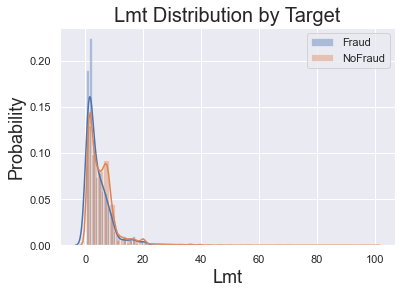

In [13]:
#连续特征分布
for col in float_col:
    distPlot(col)

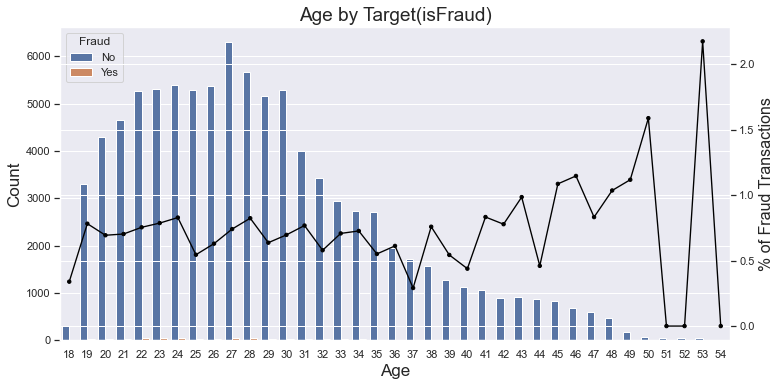

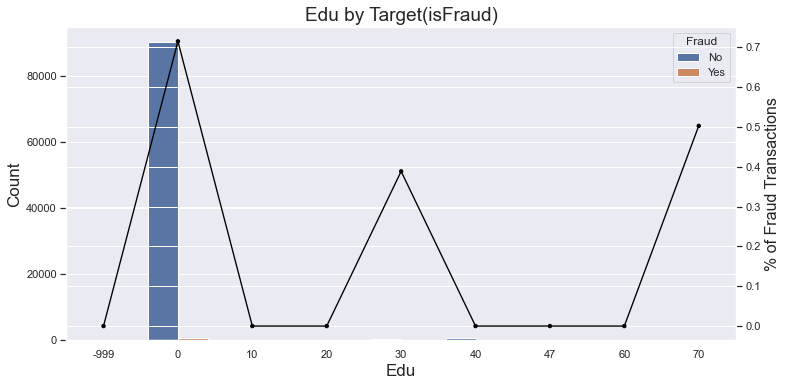

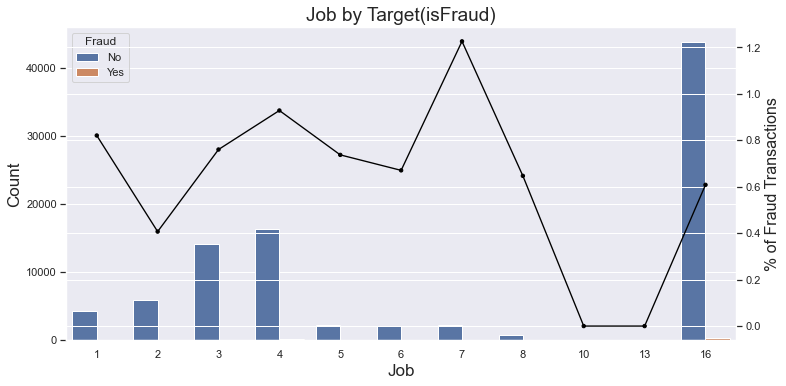

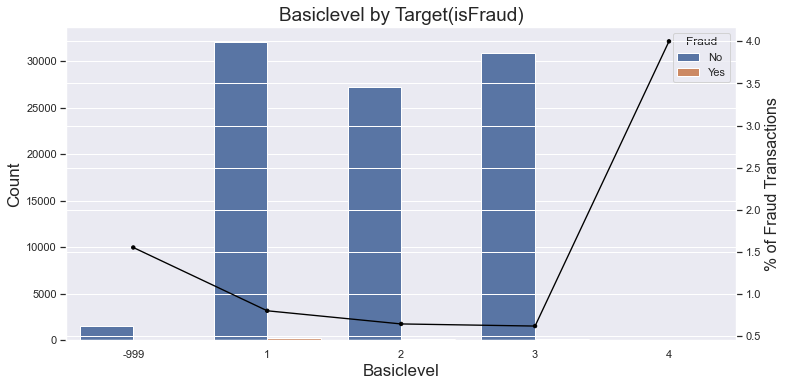

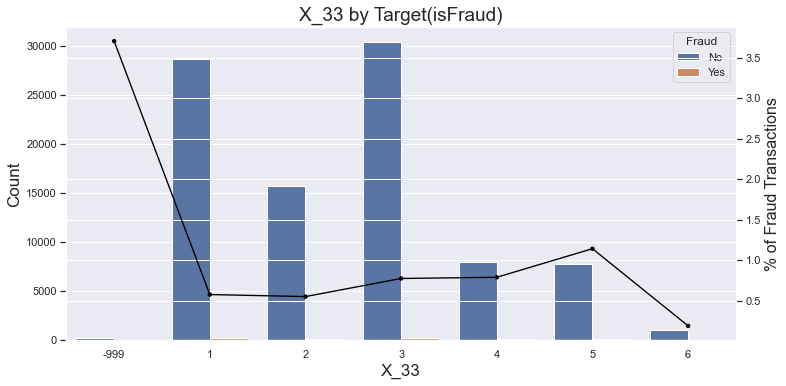

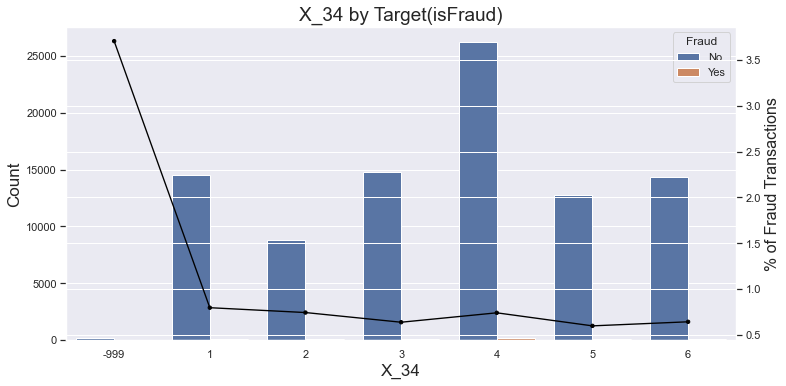

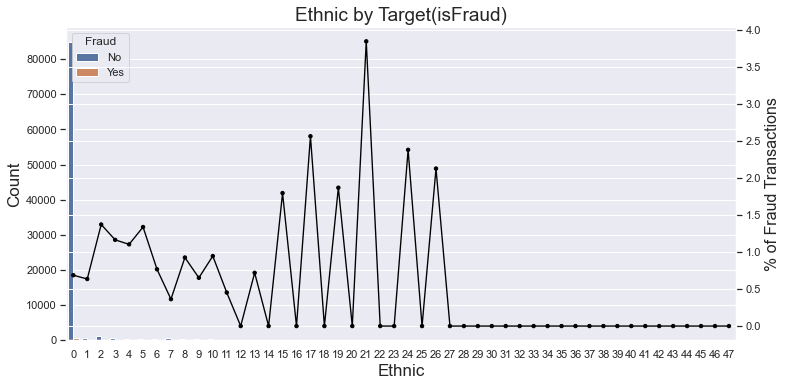

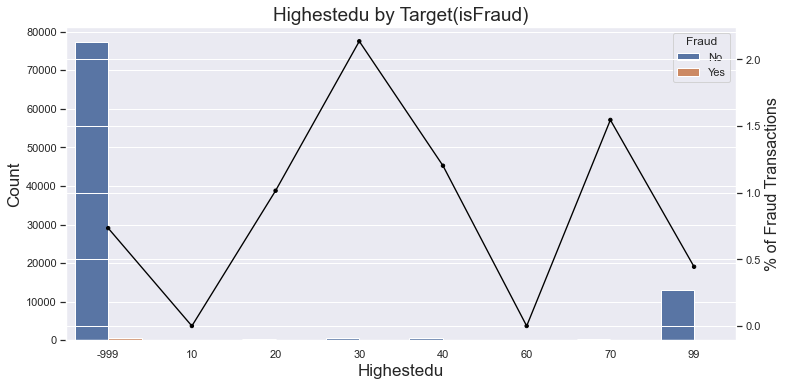

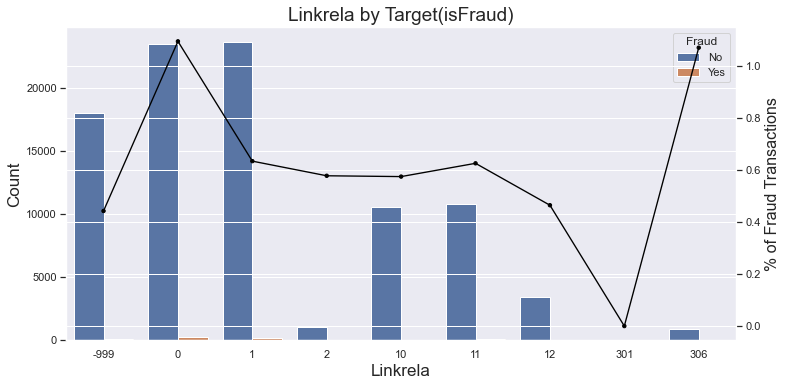

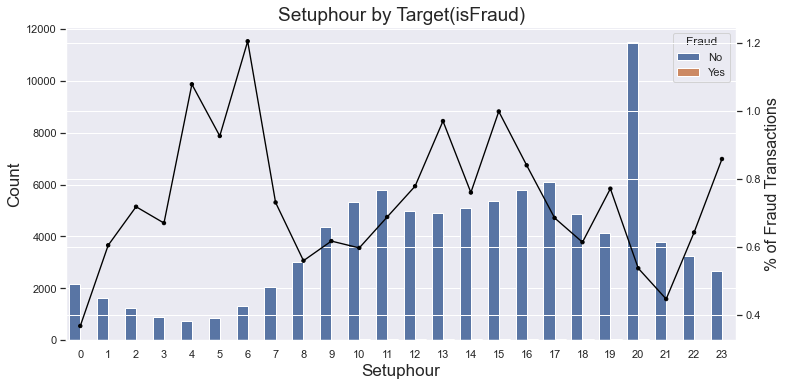

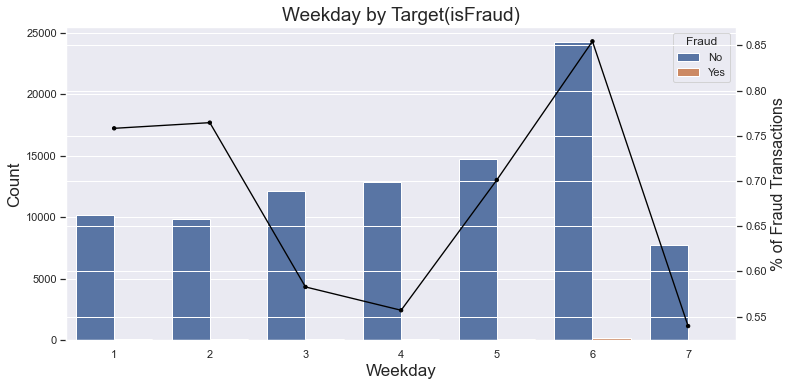

In [14]:
#离散特征分布
del_col=['id']
for i in del_col:
    if i in int_col:
        int_col.remove(i)

for col in int_col:
    catPlot(col)

数据集中共包含 104 个特征,id,certId,dist,residentAddr就是对目标无关的属性进行删除处理。

由于某些离散特征（edu、age、job、ethnic、basicLevel、certValidBegin、x_33、linkRela、highestEdu、setupHour、weekday）给出的值并非是类似1、2、3这种明显标识类别的值，而是类似40、47、70这种，所以我们当作连续特征进行woe处理

In [25]:
#非高维稀疏特征
other_col=list(train_summary[(train_summary['Uniques']<=3 )]['Name'])
#部分离散特征+连续特征，当作连续特征进行处理
float_col=list(train_summary[(train_summary['Uniques']>3 ) &(train_summary['dtypes']=='float64')]['Name'])
add_col=['age','job','ethnic','basicLevel','x_33','linkRela','highestEdu','setupHour','weekday']
float_col=float_col+add_col

#高维离散特征
int_col=list(train_summary[(train_summary['Uniques']>3 ) &(train_summary['dtypes']=='int')]['Name'])
for i in add_col:
    if i in int_col:
        int_col.remove(i)
        
#检验特征是否分的完全
len(int_col)+len(float_col)+len(other_col)==99

True

In [26]:
float_col

['lmt',
 'age',
 'job',
 'ethnic',
 'basicLevel',
 'x_33',
 'linkRela',
 'highestEdu',
 'setupHour',
 'weekday']

In [27]:
int_col

['id', 'edu', 'x_34']

# 2.特征工程

### 高维稀疏特征进行woe编码

In [28]:
float_col=['id']+float_col
ex_lis=['target','id']

bin_df=pd.concat([df[float_col],df['target']],axis=1)
bin_test=pd.concat([df_test[float_col],df_test['target']],axis=1)

# 得到切分节点  
combiner = toad.transform.Combiner()  
combiner.fit(bin_df, bin_df['target'], method='chi',
                min_samples=0.05,exclude=ex_lis)

df_bin_bound=combiner.export() 
df_bin_train= combiner.transform(bin_df)
df_bin_test=combiner.transform(bin_test)

In [29]:
t = toad.transform.WOETransformer()  
df_bin_train_woe = t.fit_transform(df_bin_train, df_bin_train['target'], 
                                      exclude=ex_lis) 
df_bin_test_woe = t.transform(df_bin_test[df_bin_train_woe.columns])  
#data = pd.concat([dev_slct3_woe, val_woe, off_woe])

In [30]:
df_bin_test_woe

,id,lmt,age,job,ethnic,basicLevel,x_33,linkRela,highestEdu,setupHour,weekday,target
58471,58472,-0.169071,0.0,-0.148549,-0.027714,-0.112912,-0.195204,0.444625,0.040254,-0.318619,0.193074,0
28346,28347,0.572776,0.0,0.261361,-0.027714,-0.112912,0.155356,0.444625,0.040254,-0.063683,0.193074,0
121263,121264,-0.394827,0.0,-0.191294,-0.027714,-0.112912,0.155356,-0.136460,0.040254,-0.029251,0.193074,0
125335,125336,0.572776,0.0,-0.148549,-0.027714,-0.112912,0.155356,-0.136460,0.040254,-0.318619,0.193074,0
77242,77243,-0.169071,0.0,0.261361,-0.027714,0.169434,-0.195204,-0.136460,0.040254,-0.318619,-0.269922,0
...,...,...,...,...,...,...,...,...,...,...,...,...
82558,82559,-0.169071,0.0,-0.148549,-0.027714,-0.112912,0.155356,0.444625,0.040254,-0.029251,-0.269922,0
14348,14349,0.572776,0.0,0.075367,0.317810,-0.112912,0.155356,0.444625,0.040254,-0.063683,-0.269922,0
65805,65806,-0.169071,0.0,-0.148549,-0.027714,-0.112912,-0.195204,-0.136460,0.040254,-0.318619,-0.269922,0
102647,102648,-0.169071,0.0,-0.148549,-0.027714,-0.112912,0.155356,-0.136460,-0.248501,0.032489,-0.192320,0


#### 高维离散特征标准化

In [31]:
# edu 标准化
edu_mean = df.edu.mean()
edu_std = df.edu.std()
# training data
df.edu = (df.edu - edu_mean) / edu_std
# test data
df_test.edu = (df_test.edu - edu_mean) / edu_std

In [32]:
# x_34 标准化
x_34_mean = df.x_34.mean()
x_34_std = df.x_34.std()
# training data
df.x_34 = (df.x_34 - x_34_mean) / x_34_std
# test data
df_test.x_34 = (df_test.x_34 - x_34_mean) / x_34_std

In [38]:
other_col_1=[col for col in other_col if 'x_' not in col]
other_col_2=[col for col in other_col if 'x_'  in col]

df_onehot=pd.DataFrame()
for i in other_col_1:
    onehot=pd.get_dummies(df[i], prefix =i)
    df_onehot=pd.concat([df_onehot,onehot],axis=1)
    
df_onehot_test=pd.DataFrame()
for i in other_col_1:
    onehot=pd.get_dummies(df_test[i], prefix =i)
    df_onehot_test=pd.concat([df_onehot_test,onehot],axis=1)

#### 拼接数据

In [39]:
df_data=pd.concat([df_bin_train_woe,df_onehot,df[int_col].drop(columns=['id']),df[other_col_2]],axis=1)
df_test=pd.concat([df_bin_test_woe,df_onehot_test,df_test[int_col].drop(columns=['id']),df_test[other_col_2]],axis=1)

In [40]:
df_data.head()

,id,lmt,age,job,ethnic,basicLevel,x_33,linkRela,highestEdu,setupHour,...,x_69,x_70,x_71,x_72,x_73,x_74,x_75,x_76,x_77,x_78
20716,20717,-0.169071,0.0,0.075367,-0.027714,0.169434,-0.195204,-0.136460,-0.248501,0.235054,...,0,1,1,0,0,1,0,0,0,0
34903,34904,-0.394827,0.0,0.075367,-0.027714,0.169434,-0.195204,-0.136460,0.040254,-0.029251,...,0,1,1,0,0,1,1,0,0,0
91600,91601,-0.169071,0.0,-0.148549,-0.027714,-0.112912,-0.195204,0.444625,0.040254,0.032489,...,0,1,1,0,0,1,1,1,0,0
101506,101507,-0.169071,0.0,-0.148549,-0.027714,-0.112912,-0.195204,-0.136460,-0.248501,-0.318619,...,0,1,1,0,0,1,0,0,0,0
45230,45231,-0.394827,0.0,-0.191294,-0.027714,0.169434,0.155356,0.444625,0.040254,0.235054,...,0,1,1,0,0,1,0,0,0,0


In [41]:
df_test.head()

,id,lmt,age,job,ethnic,basicLevel,x_33,linkRela,highestEdu,setupHour,...,x_69,x_70,x_71,x_72,x_73,x_74,x_75,x_76,x_77,x_78
58471,58472,-0.169071,0.0,-0.148549,-0.027714,-0.112912,-0.195204,0.444625,0.040254,-0.318619,...,0,1,0,0,0,1,0,0,0,0
28346,28347,0.572776,0.0,0.261361,-0.027714,-0.112912,0.155356,0.444625,0.040254,-0.063683,...,0,1,1,0,0,1,0,0,0,0
121263,121264,-0.394827,0.0,-0.191294,-0.027714,-0.112912,0.155356,-0.136460,0.040254,-0.029251,...,0,1,1,0,0,1,0,0,0,0
125335,125336,0.572776,0.0,-0.148549,-0.027714,-0.112912,0.155356,-0.136460,0.040254,-0.318619,...,0,1,1,0,0,1,0,0,0,0
77242,77243,-0.169071,0.0,0.261361,-0.027714,0.169434,-0.195204,-0.136460,0.040254,-0.318619,...,0,1,1,0,0,1,0,0,0,0


至此数据预处理过程全部完成，主要工作总结和结论如下：
1. 标准化处理：聚合相似表现的属性取值，同时起到降维的作用。
2. 高维稀疏特征woe编码：

In [42]:
df_data.to_csv('./df_data_end.csv')
df_test.to_csv('./df_test_end.csv')

# 3.特征选择

In [2]:
df_data=pd.read_csv('./df_data_end.csv',index_col=0).drop(columns='id')
df_test=pd.read_csv('./df_test_end.csv',index_col=0).drop(columns='id')

In [85]:
df_data.target.value_counts()

0    91766
1      652
Name: target, dtype: int64

In [89]:
df_test.target.value_counts()

0    39301
1      307
Name: target, dtype: int64

In [30]:
model_features=list(df_data.columns)
model_features.remove('target')

[LightGBM] [Warning] Unknown parameter: sample_pos_weight
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[1]	training's auc: 0.648987	valid_1's auc: 0.673684
[2]	training's auc: 0.651793	valid_1's auc: 0.675439
[3]	training's auc: 0.682044	valid_1's auc: 0.687193
[4]	training's auc: 0.689873	valid_1's auc: 0.68813
[5]	training's auc: 0.700769	valid_1's auc: 0.701017
[6]	training's auc: 0.702394	valid_1's auc: 0.698963
[7]	training's auc: 0.705438	valid_1's auc: 0.702674
[8]	training's auc: 0.709971	valid_1's auc: 0.707529
[9]	training's auc: 0.712188	valid_1's auc: 0.7075

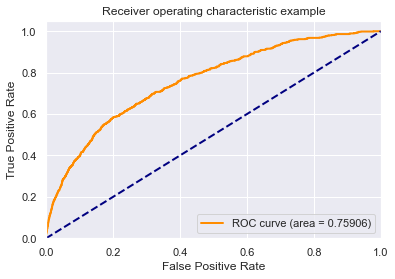

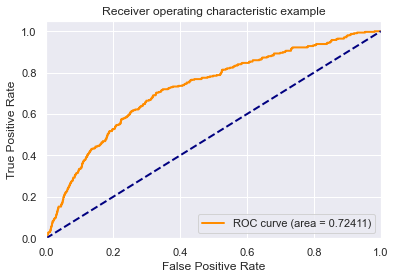

In [36]:
#model
lgb_model =lgb.LGBMClassifier(boosting_type = 'gbdt',
                       objective = 'binary',
                       metric = 'auc',
                       learning_rate = 0.1,
                       n_estimators = 30,
                       max_depth = 4,
                       num_leaves = 10,
                       max_bin = 40,
                       min_data_in_leaf = 4,
                       bagging_fraction = 0.6,
                       bagging_freq = 0,
                       feature_fraction = 0.8,
                       sample_pos_weight = 136#处理样本不均衡
                       )
lgb_model.fit(x,y,eval_set = [(x,y),(test_x,test_y)],eval_metric = 'auc')
lgb_auc=lgb_model.best_score_['valid_1']['auc'],
feature_importance = pd.DataFrame({'name':lgb_model.booster_.feature_name(),
                                   'importance':lgb_model.feature_importances_}).sort_values(by=['importance'],ascending=False)
#ks
pred = lgb_model.predict_proba(x)[:,1]
fpr_lgb,tpr_lgb,_ = roc_curve(y,pred)
print(abs(fpr_lgb - tpr_lgb).max())
    
pred = lgb_model.predict_proba(test_x)[:,1]
fpr_lgb,tpr_lgb,_ = roc_curve(test_y,pred)
print(abs(fpr_lgb - tpr_lgb).max())
#auc
y_pred = lgb_model.predict_proba(x)[:,1]
plotROC(y, y_pred)

y_pred = lgb_model.predict_proba(test_x)[:,1]
plotROC(test_y, y_pred)

In [41]:
feature_importance[feature_importance.importance>0].name

9                 weekday
8               setupHour
2                     job
5                    x_33
0                     lmt
12          loanProduct_3
79                   x_46
25       unpayOtherLoan_1
6                linkRela
13               gender_1
105                  x_72
31                isNew_0
10          loanProduct_1
55                   x_20
15           bankCard_0.0
101                  x_68
28      unpayNormalLoan_1
4              basicLevel
34                   x_34
21        unpayIndvLoan_0
33                    edu
100                  x_67
14               gender_2
3                  ethnic
108                  x_75
51                   x_16
88                   x_55
99                   x_66
49                   x_14
64                   x_29
85                   x_52
107                  x_74
83                   x_50
95                   x_62
84                   x_51
22        unpayIndvLoan_1
7              highestEdu
106                  x_73
32          

In [42]:
model_features=list(feature_importance[feature_importance.importance>0].name)

# 4.模型训练

In [46]:
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.neighbors import KNeighborsClassifier 

In [21]:
#ROC
def plotROC(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[2], tpr[2], _ = roc_curve(y_test, y_score)
    roc_auc[2] = auc(fpr[2], tpr[2])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test, y_score)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # plot it
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.5f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

#### 逻辑回归

In [34]:
x = df_data[model_features]
y = df_data['target']

test_x =  df_test[model_features]
test_y = df_test['target']

train_ks :  0.30984416351592586
evl_ks :  0.35226801715018813


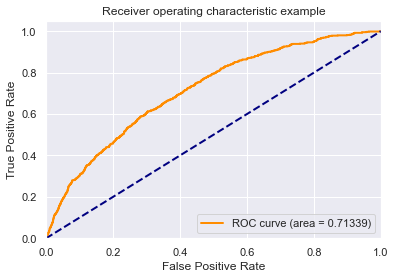

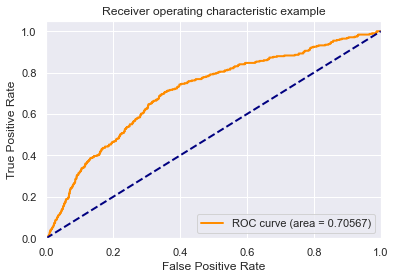

In [35]:
#model
lr_model = LogisticRegression(C=0.1,class_weight='balanced')
lr_model.fit(x,y)
#ks
y_pred = lr_model.predict_proba(x)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(test_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(test_y,y_pred)
evl_ks = abs(fpr_lr - tpr_lr).max()
print('evl_ks : ',evl_ks)
#auc
y_pred = lr_model.predict_proba(x)[:,1]
plotROC(y, y_pred)

y_pred = lr_model.predict_proba(test_x)[:,1]
plotROC(test_y, y_pred)

#### lightgbm

In [43]:
x = df_data[model_features]
y = df_data['target']

test_x =  df_test[model_features]
test_y = df_test['target']

[LightGBM] [Warning] Unknown parameter: sample_pos_weight
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[1]	training's auc: 0.647022	valid_1's auc: 0.666427
[2]	training's auc: 0.656383	valid_1's auc: 0.667184
[3]	training's auc: 0.670414	valid_1's auc: 0.678235
[4]	training's auc: 0.687182	valid_1's auc: 0.69205
[5]	training's auc: 0.699922	valid_1's auc: 0.702666
[6]	training's auc: 0.70257	valid_1's auc: 0.706884
[7]	training's auc: 0.705039	valid_1's auc: 0.712178
[8]	training's auc: 0.708411	valid_1's auc: 0.7105
[9]	training's auc: 0.713344	valid_1's auc: 0.707791


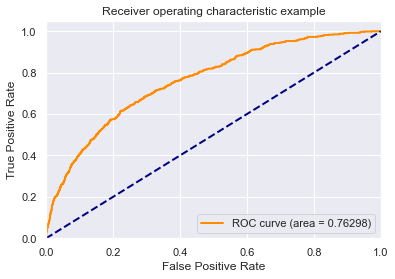

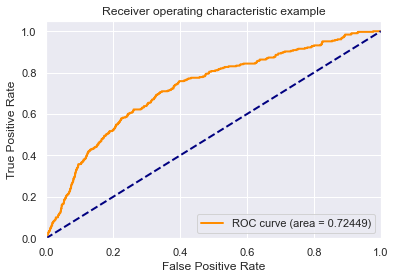

In [53]:
#model
lgb_model =lgb.LGBMClassifier(boosting_type = 'gbdt',
                       objective = 'binary',
                       metric = 'auc',
                       learning_rate = 0.1,
                       n_estimators = 30,
                       max_depth = 4,
                       num_leaves = 10,
                       max_bin = 40,
                       min_data_in_leaf = 4,
                       bagging_fraction = 0.6,
                       bagging_freq = 0,
                       feature_fraction = 0.8,
                       sample_pos_weight = 136#处理样本不均衡
                       )
lgb_model.fit(x,y,eval_set = [(x,y),(test_x,test_y)],eval_metric = 'auc')
lgb_auc=lgb_model.best_score_['valid_1']['auc'],
feature_importance = pd.DataFrame({'name':lgb_model.booster_.feature_name(),
                                   'importance':lgb_model.feature_importances_}).sort_values(by=['importance'],ascending=False)
#ks
pred = lgb_model.predict_proba(x)[:,1]
fpr_lgb,tpr_lgb,_ = roc_curve(y,pred)
print(abs(fpr_lgb - tpr_lgb).max())
    
pred = lgb_model.predict_proba(test_x)[:,1]
fpr_lgb,tpr_lgb,_ = roc_curve(test_y,pred)
print(abs(fpr_lgb - tpr_lgb).max())
#auc
y_pred = lgb_model.predict_proba(x)[:,1]
plotROC(y, y_pred)

y_pred = lgb_model.predict_proba(test_x)[:,1]
plotROC(test_y, y_pred)

In [83]:
feature_importance

,name,importance
2,job,20
0,weekday,17
4,lmt,15
1,setupHour,14
3,x_33,13
5,loanProduct_3,11
6,x_46,11
7,unpayOtherLoan_1,10
8,linkRela,10
18,x_34,9


#### xgboost

In [47]:
best_params={'bagging_fraction': 0.7181085921260275, 'colsample_bytree': 0.6694113492095588, 
             'feature_fraction': 0.797841537114919, 'gamma': 0.06849041218948591, 
             'learning_rate': 0.05183533542460199, 'max_depth': 2, 
             'min_child_samples': 110, 'num_leaves': 10, 
             'reg_alpha': 0.24079829116979645, 'reg_lambda': 0.07970627806518778, 'subsample': 0.8}
xgb = xgb.XGBClassifier(
    n_estimators=300,
    **best_params,
    tree_method='hist',
    eval_metric="auc",
    n_jobs=-1,
    scale_pos_weight=136
)
xgb.fit(x,y.values.ravel())

[16:13:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(bagging_fraction=0.7181085921260275, base_score=0.5,
              booster='gbtree', callbacks=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6694113492095588,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_fraction=0.797841537114919,
              gamma=0.06849041218948591, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05183533542460199, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=2, max_leaves=0,
              min_child_samples=110, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=-1,
              num_leaves=10, num_parallel_tree=1, ...)

train_ks :  0.3890249526369351
evl_ks :  0.35938795931210604


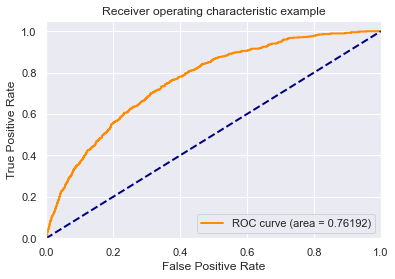

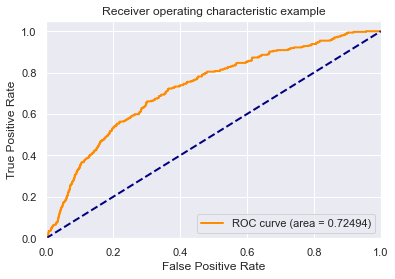

In [48]:
#ks
y_pred = xgb.predict_proba(x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr - tpr_lr).max()
print('train_ks : ',train_ks)

y_pred = xgb.predict_proba(test_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(test_y,y_pred)
evl_ks = abs(fpr_lr - tpr_lr).max()
print('evl_ks : ',evl_ks)
#auc
y_pred = xgb.predict_proba(x)[:,1]
plotROC(y, y_pred)

y_pred = xgb.predict_proba(test_x)[:,1]
plotROC(test_y, y_pred)

#### catboost

In [70]:
cat_params = {'learning_rate': 0.05, 'depth': 2, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
              'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
cat = CatBoostClassifier(iterations=20000, eval_metric='Logloss', **cat_params)
cat.fit(x,y.values.ravel(), 
        eval_set=(test_x, test_y), use_best_model=True, verbose=1000)

0:	learn: 0.5786137	test: 0.5788873	best: 0.5788873 (0)	total: 9.1ms	remaining: 3m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0430805901
bestIteration = 538

Shrink model to first 539 iterations.


train_ks :  0.3745418963062759
evl_ks :  0.36903189424111427


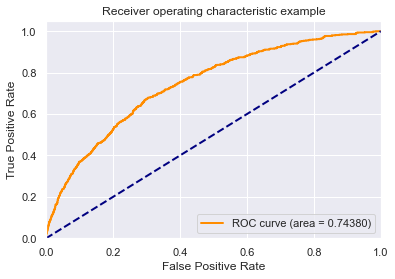

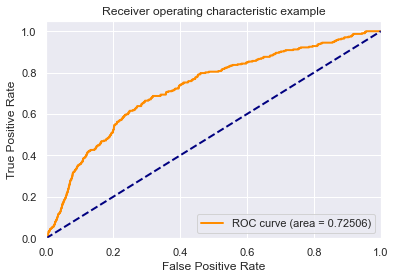

In [71]:
#ks
y_pred = cat.predict_proba(x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr - tpr_lr).max()
print('train_ks : ',train_ks)

y_pred = cat.predict_proba(test_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(test_y,y_pred)
evl_ks = abs(fpr_lr - tpr_lr).max()
print('evl_ks : ',evl_ks)

#auc
y_pred = cat.predict_proba(x)[:,1]
plotROC(y, y_pred)

y_pred = cat.predict_proba(test_x)[:,1]
plotROC(test_y, y_pred)

#### 模型融合

In [74]:
y_pre_lgb=lgb_model.predict_proba(x)[:,1]
y_pred_xgb = xgb.predict_proba(x)[:,1]
y_pre_cat=cat.predict_proba(x)[:,1]
train_oof = pd.DataFrame({'y_pre_lgb': y_pre_lgb, 
                          'y_pred_xgb': y_pred_xgb, 
                          'y_pre_cat': y_pre_cat})

y_pre_lgb1=lgb_model.predict_proba(test_x)[:,1]
y_pred_xgb1 = xgb.predict_proba(test_x)[:,1]
y_pre_cat1=cat.predict_proba(test_x)[:,1]
test_predict = pd.DataFrame({'y_pre_lgb1': y_pre_lgb1, 
                          'y_pred_xgb1': y_pred_xgb1, 
                          'y_pre_cat1': y_pre_cat1})

#### Voting_weight

In [79]:
Voting_train_soft_weight=(y_pre_lgb+100*y_pred_xgb+1000*y_pre_cat)/201
Voting_test_soft_weight=(y_pre_lgb1+100*y_pred_xgb1+1000*y_pre_cat1)/201

fpr_lr_train,tpr_lr_train,_ = roc_curve(y,Voting_train_soft_weight)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

fpr_lr,tpr_lr,_ = roc_curve(test_y,Voting_test_soft_weight)
evl_ks = abs(fpr_lr - tpr_lr).max()
print('evl_ks : ',evl_ks)

train_ks :  0.39130308631088756
evl_ks :  0.36631346128646963


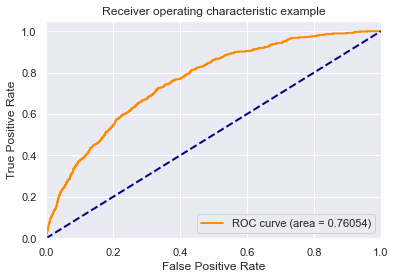

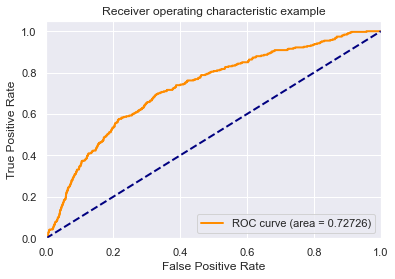

In [80]:
plotROC(y, Voting_train_soft_weight)
plotROC(test_y, Voting_test_soft_weight)

#### stacking

In [77]:
lr_final = LogisticRegression().fit(train_oof, y)

train_ks :  0.38941387864492366
evl_ks :  0.358293425161704


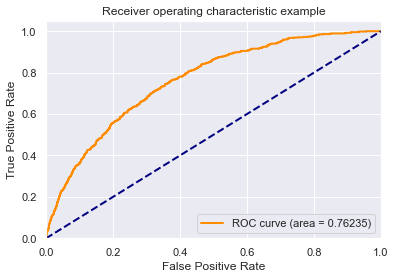

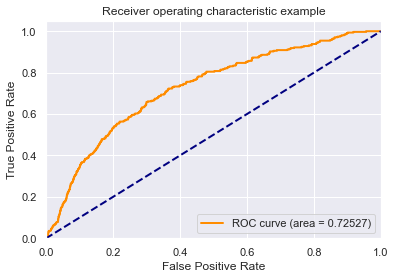

In [78]:
y_pred1 = lr_final.predict_proba(train_oof)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred1)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred2 = lr_final.predict_proba(test_predict)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(test_y,y_pred2)
evl_ks = abs(fpr_lr - tpr_lr).max()
print('evl_ks : ',evl_ks)

#auc
y_pred = lr_final.predict_proba(train_oof)[:,1]
plotROC(y, y_pred)

y_pred = lr_final.predict_proba(test_predict)[:,1]
plotROC(test_y, y_pred)

# 总结

#### 最好结果

| 模型 | train_ks | evl_ks | train_auc |test_auc|
| ------ | ------ | ------ | ------ | ------ |
| Catboost | 0.3745 | 0.3690 | 0.744 | 0.725|
| Voting_weight | 0.3913 | 0.3663 | 0.761 | 0.727|

catboost的ks指标优于模型融合后Voting_weight；
模型融合后Voting_weight的auc优于cat boost。

由于数据并不是通过跨时间来分割验证数据，数据提供方也是通过auc来判断模型优劣，因此，最优模型选择voting_weight.

#### 跟踪观察特征

In [84]:
feature = pd.DataFrame({'name':feature_importance.head(20).name},index=range(20))
feature                                  

,name
0,weekday
1,setupHour
2,job
3,x_33
4,lmt
5,loanProduct_3
6,x_46
7,unpayOtherLoan_1
8,linkRela
9,gender_1
